# Statistical Experiments and Significance Testing

The goal is to design an experiment in order to confirm or reject a hypothesis. Data Scientist often conducts continual experiments, particularly regarding user interface and product marketing.

## Content
- **A/B Testing**
- **Hypothesis Tests**
- **Resampling**
    - Example: Web Stickiness
- **Statistical Significance and p-Values**
    - Table for ecommerce experiment results
- **t-Tests**
- **Multiple Testing**
- **ANOVA**
    - Plotting boxplots of the four webpages
    - Compute the permutation test (ANOVA)
- **F-Statistic**
- **Chi-Square Test**
    - Chi-Square Test: A Resampling Appproach
    - Compute permutation test (chi-square)
    - Chi-Square Test: Statistical Theory
    - Plotting chi-square distribution with different degrees of freedom
- **Fisher's Exact Test**
- **Multi-Arm Bandit**
- **Power and Sample Size**
    - Estimate how big a sample you will need

## A/B Testing
Important key terms: 
- **Treatment**
- **Treatment group**
- **Control group**
- **Randomization**
- **Subjects**
- **Test statistic**

Data Scientist are less interested in the question:
- It the difference between price A and price B statistically significant?
than in the question:
- Which, out of multiple possible prices, is best?

For this, a relatively new type of experimental design is used: **the multi-arm bandit**

## Hypothesis Tests
Important key terms: 
- **Null hypothesis**
- **Alternative hypothesis**
- **One-way test**
- **Two-way test**

An A/B test is typically constructed with a hypothesis in mind. Why not just look at the outcome of the experiment and go with whichever treatment does better? 
- Failure to anticipate extreme events
- Misinterpret random events as having patterns of some significance. 

Recall the misinterpretation of randomness (50 written coin tosses vs. 50 real coin tosses)

Note that one-tial vs. two-tail is a confusing subject, and not that relevant to data science, where the percision of p-value calculations is not terribly important.

## Resampling
Important key terms: 
- **Permutation test** (for visualization: https://www.jwilber.me/permutationtest/)
- **Resampling**
- **With or without replacement**

### Example: Web Stickiness

Using a proxy variable a company decides to measure which two presentations does a better job selling this relatively high-value service. One potential proxy variable for our company is the number of clicks on the detailed landing page. A better on is how long people spend on the page (average session time), comparing page A to page B.
 
Note: Google Analytics cannot measure session time for the last session a person visits so it records it as a zero. Additional processiong to remove those sessions is required.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power


%matplotlib inline

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [5]:
session_times.Time = 100*session_times.Time 

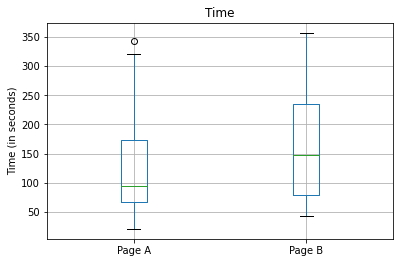

In [6]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

Note: page B leads to longer sessions than page A.

In [7]:
mean_a = session_times[session_times['Page'] == 'Page A']['Time'].mean()
mean_b = session_times[session_times['Page'] == 'Page B']['Time'].mean()
mean_b-mean_a

35.66666666666667

Page B has session times that are greater than those of page A by 35.67 seconds, on average. The question is whether this difference is within the range of what random chance might produce, i.e. is statistically significant. One way to answer this is with a permutation test

In [8]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [9]:
session_times['Page'].value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

In [10]:
nA = session_times[session_times['Page'] == 'Page A'].shape[0]
nB  = session_times[session_times['Page'] == 'Page B'].shape[0]
print(nA, nB)
print(perm_fun(session_times.Time, nA, nB))

21 15
84.23809523809524


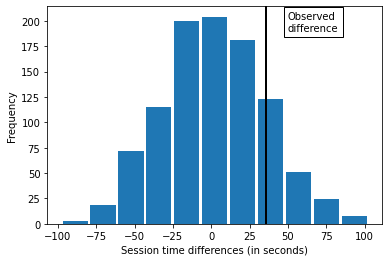

In [11]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots()
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b-mean_a, color='black', lw=2)
ax.text(50,190, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
plt.show()

The histogram shows that mean difference of random permutations often exceed the observed difference in session times. This happens approx. 12% of the time.

In [12]:
np.mean(perm_diffs > mean_b - mean_a)

0.151

Thus the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

## Statistical Significance and p-Values
Important key terms: 
- **p-value** (probability of obtaining results as unusual or extreme as the observed results)
- **Alpha**
- **Type 1 error**
- **Type 2 error**

### Table for ecommerce experiment results

|Outcome|Price A|Price B|
|---|---|---|
|Conversion|200|182|
|No Conversion|23,539|22,406|

Price A converts almost 5% better than price B. Note that it's tempting to consider this 'big data' with 45000 data points (significance testing is needed only to account for sampling variability in small samples) but the value of interest only has hundreds of data points. So we can ask if the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?

Observed difference: 0.0368%


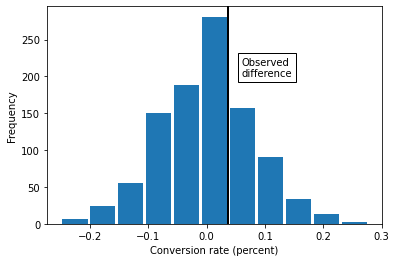

In [13]:
obs_pct_diff = 100*(200/(23539+200)-182/(22406+182))
print('Observed difference: {:.4f}%'.format(obs_pct_diff))
conversion = [0]*(23593+22406)
conversion.extend([1]*(200+182))
conversion = pd.Series(conversion)

perm_diffs = [100*perm_fun(conversion, 23539+200, 22406+182) for _ in range(1000)]
fig, ax = plt.subplots()
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(.06,200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [14]:
# p-value
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.296

Note that we didn't need to use a permutation test to get a p-value. We have binomial distribution, we can approximate the p-value

In [15]:
survivors = np.array([[200, 23593], [182, 22406]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)
print('p-value for single sided test: {:.4f}'.format(p_value/2))

p-value for single sided test: 0.3581


What the p-value actully represents is: given a chance model, results as extreme as the observed result could occur. Significance tests are typically structured to minimize Type 1 errors. For Data Science p-value is a decision tool in an experiment, merely another point of information bearing on a decision. For example, p-values are sometimes used as intermediate inputs in some statisitcal or machine learning models - a feature might be included in or excluded from a model depending on its p-value.

## t-Tests
Important key terms: 
- **Test statistic** 
- **t-statistic**
- **t-distribution**

All significance tests require that you specify a test statistic to measure the effect you are intrested in and help you determine whether that observed effect lies within the range of normal chance variation. A good approximation to the permutation distribution was the t-test. It is used for the very common two-sample comparison-A/B test-in which the data is numeric.

In [16]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print('p-value for single sided test: {:.4f}'.format(res.pvalue/2))

p-value for single sided test: 0.1408


The alternative hypothesis is that the session time mean for page A is less than that for page B. The p-value of .1408 is fairly close to the permutation test p-values.

## Multiple Testing
Important key terms: 
- **Type 1 error** 
- **False discorvery rate**
- **Alpha inflation** (1-probability of that all will be nonsignificant)
- **Adjustment of p-values**
- **Overfitting**

Given 20 predictors and 1 outcome, all randomly generated, the odd are pretty good that at least one predictor will (falsely) turn out to be statistically significant if you do a series of 20 significance tests at an alpha level = .05 level (type 1 error).

## ANOVA
Important key terms: 
- **Pairwise comparison** 
- **Omnibus test**
- **Decomposition of variance**
- **F-statistic**
- **SS**

The statistical procedure that tests for a statistically significant difference among the group is called analysis of variance (ANOVA).

In [17]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


### Plotting boxplots of the four webpages

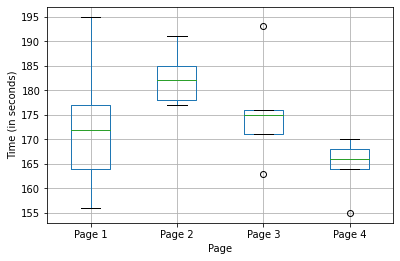

In [18]:
ax = four_sessions.boxplot(by='Page', column='Time')
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')
plt.show()

### Compute the permutation test (ANOVA)

In [19]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means: ', four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ', observed_variance)

Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655


In [20]:
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

In [21]:
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Pr(Prob) 0.07933333333333334


The p-value, given by Pr(Prob) is .08. In other words, given the same underlying stickiness, 9.3% of the time the response rate among four pages might differ as much as was actually observed, just by chance. This degree of improbability falls short of the traditional statistical threshold of 5%, so we conclude that the difference among the four pages could have arisen by chance.

## F-Statistic
The F-statistic is based on the ratio of the variance across group means to the variance due to residual error. The higher the ratio, the more statistically significant the result.

In [22]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


## Chi-Square Test
Important key terms: 
- **Chi-square statistic** 
- **Expectation or expected**

This chi-square test is used with count data to test how well it fits some expected distribution

### Chi-Square Test: A Resampling Appproach

In [23]:
clicks = pd.read_csv(CLICK_RATE_CSV)
clicks = clicks.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [24]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


### Compute permutation test (chi-square)

In [25]:
box = [1]*34
box.extend([0]*2966)
random.shuffle(box)

In [26]:
def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect)**2 / expect
                                  for observe in row])

    return np.sum(pearson_residuals)

In [27]:
expected_clicks = 34/3
expected_nonclicks = 1000-expected_clicks
expected = [expected_clicks, expected_nonclicks]
chi2observed = chi2(clicks.values, expected)
chi2observed

1.6659394708658917

In [28]:
def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_nonclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_nonclicks], expected)

In [29]:
perm_chi2 = [perm_fun(box) for _ in range(2000)]
resampled_p_value = sum([val > chi2observed for val in perm_chi2]) / len(perm_chi2)
print('Observed chi2: {:.4f}'.format(chi2observed))
print('Resampled p-value: {:.4f}'.format(resampled_p_value))

Observed chi2: 1.6659
Resampled p-value: 0.4630


### Chi-Square Test: Statistical Theory

In [30]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print('Observed chi2: {:.4f}'.format(chi2observed))
print('p-value: {:.4f}'.format(pvalue))

Observed chi2: 1.6659
p-value: 0.4348


The p-value is a bit less than the resampling p-value: this is because the chi-square distribution is only an approximation of the actual distribution of the statistic.

### Plotting chi-square distribution with different degrees of freedom

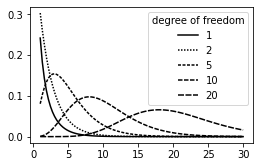

In [31]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='degree of freedom')

plt.show()

## Fisher's Exact Test

The chi-square distribution is a good approximation of the shuffled resampling test, except when counts are extremely low (single digits < 5). The resampling procedure will yield more accurate p-values. In fact, most statistical software has a procedure to actually enumerate all the possible rearrangements that can occur, tabulate their frequencies, and determine exactly how extreme the observed result is. This is called **Fisher's exact test**.

## Multi-Arm Bandit
Important key terms: 
- **Multi-arm bandit** 
- **Arm**
- **Win**

Bandit algorithms, which are very popular in web testing, allow you to test multiple treatments at once and reach conclusions faster than traditional statistical designs.

## Power and Sample Size
Important key terms: 
- **Effect size** 
- **Power**
- **Significance level**

The most common use of power calculations is to estimate how big a sample you will need.

### Estimate how big a sample you will need

In [32]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [33]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
